In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

Update the path to checkpoint here upon uploading and unzip. 

In [20]:
! unzip '/content/checkpoints1.zip' 

Archive:  /content/checkpoints1.zip
   creating: content/checkpoints/
   creating: content/checkpoints/train/
  inflating: content/checkpoints/train/ckpt-3.data-00000-of-00002  
  inflating: content/checkpoints/train/ckpt-1.index  
  inflating: content/checkpoints/train/checkpoint  
  inflating: content/checkpoints/train/ckpt-1.data-00001-of-00002  
  inflating: content/checkpoints/train/ckpt-4.index  
  inflating: content/checkpoints/train/ckpt-4.data-00000-of-00002  
  inflating: content/checkpoints/train/ckpt-3.data-00001-of-00002  
  inflating: content/checkpoints/train/ckpt-2.data-00001-of-00002  
  inflating: content/checkpoints/train/ckpt-3.index  
  inflating: content/checkpoints/train/ckpt-2.data-00000-of-00002  
  inflating: content/checkpoints/train/ckpt-1.data-00000-of-00002  
  inflating: content/checkpoints/train/ckpt-4.data-00001-of-00002  
  inflating: content/checkpoints/train/ckpt-2.index  


## Building Vocabulary
Download the anotations to create the vocabulary

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
# image_folder = '/train2014/'
# if not os.path.exists(os.path.abspath('.') + image_folder):
#   image_zip = tf.keras.utils.get_file('train2014.zip',
#                                       cache_subdir=os.path.abspath('.'),
#                                       origin = 'http://images.cocodataset.org/zips/train2014.zip',
#                                       extract = True)
#   PATH = os.path.dirname(image_zip) + image_folder
#   os.remove(image_zip)
# else:
#   PATH = os.path.abspath('.') + image_folder

252878848/252872794 [==============================] - 5s 0us/step


In [0]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    # full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    # all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
# train_captions, img_name_vector = shuffle(all_captions,
#                                           all_img_name_vector,
#                                           random_state=1)

train_captions = shuffle(all_captions, random_state=1)
# Select the first 50000 captions from the shuffled set
num_examples = 50000
# train_captions = train_captions[:num_examples]
# img_name_vector = img_name_vector[:num_examples]

train_captions = train_captions[:num_examples]


In [5]:
len(train_captions), len(all_captions)

(50000, 414113)

In [0]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img) # -1 to 1
    return img, image_path

In [7]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


## Preprocessing and tokenization of the captions

1.  Tokenizing the captions to give a  vocabulary of all of the unique words.
2.  Limiting vocabulary size to the top 5,000 words replacing rest of other words by "UNK"
3.  Create word-to-index and index-to-word mappings.
4.  Finally, you pad all sequences to be the same length as the longest one.

In [0]:
# Find the maximum length of caption
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [13]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
print('Max Length (Training Sequence): ', max_length)

Max Length (Training Sequence):  49


In [0]:
# img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
#                                                                     cap_vector,
#                                                                     test_size=0.2,
#                                                                     random_state=0)

In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
features_shape = 2048
attention_features_shape = 64

## Model Definations


In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
class CNN_Encoder(tf.keras.Model):
    # We have extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_path = "/content/content/checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [0]:
# ckpt.restore(ckpt_manager.latest_checkpoint)

In [0]:
start_epoch = 20
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

  # checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Caption evaluation and generation.

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [0]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [0]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## Test new image for caption here.
Due to resource constraint, the model was trained on a limitted amount of data, as test image could be very different from the trained image, the coption someimes are super weird. "Bear with us!"  



In [0]:
# Local image test here

def generate_caption_local_path(image_path):
  result, attention_plot = evaluate(image_path)
  print ('Predicted Caption:', ' '.join(result))
  plot_attention(image_path, result, attention_plot)
  return image_path

In [0]:
# Image from Internet

def generate_caption_internet(image_url):
  print(image_url)
  image_extension = image_url[-4:]
  image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
  result, attention_plot = evaluate(image_path)
  print ('Prediction Caption:', ' '.join(result))
  plot_attention(image_path, result, attention_plot)
  return image_path

https://images.all-free-download.com/images/graphiclarge/sparrow_cute_looking_beach_608241.jpg
Prediction Caption: the small bird sitting by a wall on an area <end>


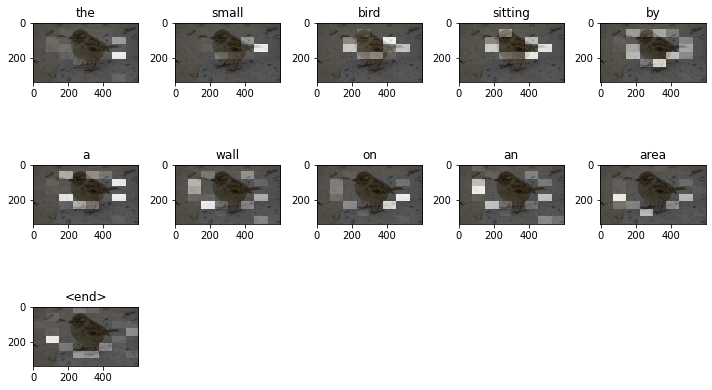

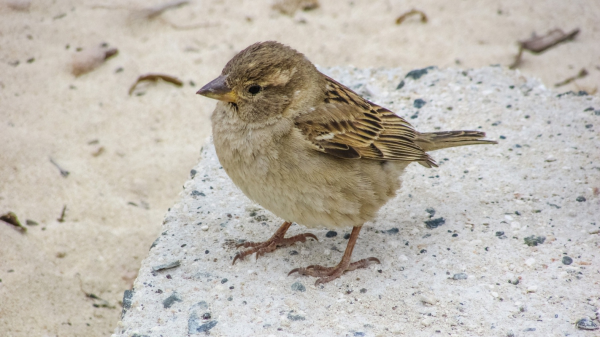

In [84]:
image_path = generate_caption_internet('https://images.all-free-download.com/images/graphiclarge/sparrow_cute_looking_beach_608241.jpg')
Image.open(image_path)

https://images.all-free-download.com/images/graphiclarge/sparrow_cute_looking_beach_608241.jpg
172032/165275 [===============================] - 0s 2us/step
Prediction Caption: a small bird is sitting on a bird on the dirt pile <end>


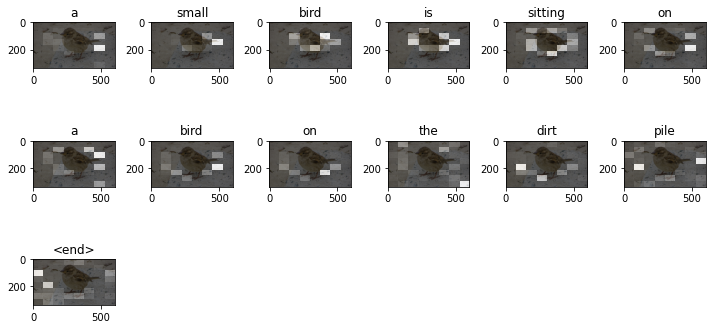

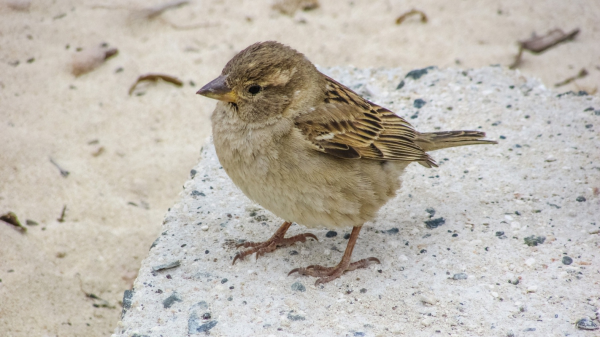

In [27]:
image_path = generate_caption_internet('https://images.all-free-download.com/images/graphiclarge/sparrow_cute_looking_beach_608241.jpg')
Image.open(image_path)